# Bias in OLAP Queries: Detection, Explanation, and Removal;

## Summary and Toy Example

### Preliminaries: 
$D$: Some Database

$T$: Treatment; the original query variable. More specifically we assign a control, $T=t_0$, and treatment $T=t_1$ subpopulations. 

$Y$: The output. We are usually interested in the average of $Y$ on the two subgroups

$Z$: Set of covariates

$M$: Set of mediators

$\Gamma_i$ (or $C$): Set of conditions 


At first glance, when we intend to run a group by query to see aggregation on some output, $Y$, of certain treatments, $T$ with condition, $C$ we perform the following SQL operation:

$\texttt{SELECT avg(Y) FROM D WHERE C GROUP BY T}$


Which translates to  $E[Y|T, C]$ for $T = {t_0 , t_1}$

But this query is likely to be biased.

### Setup:

Let's take a look at the Adult data used in the HypDB paper:

In [1]:
import sqlite3
from sqlite3 import Error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import figure
import matplotlib.image as mpimg

#data from: https://github.com/CoreyCole/HypDB/blob/master/demo/server/resources/data/binadult.csv
#csv file provided in folder

#create and connect to adult.db database and import csv file into adult table
conn = sqlite3.connect('adult.db')
df = pd.read_csv('binadult.csv')
df.to_sql('adult', conn, if_exists='replace', index=False)
cur = conn.cursor()


print("Information from adult table:\n\nSchema:")
query = """SELECT sql FROM sqlite_master WHERE name='adult';"""
cur.execute(query)
rows = cur.fetchall()
print(rows[0][0])

query = """SELECT count(*) FROM adult;"""
cur.execute(query)
rows = cur.fetchall()
print("\nObseravtions: " + str(rows[0][0]))


Information from adult table:

Schema:
CREATE TABLE "adult" (
"age" TEXT,
  "workclass" TEXT,
  "education" TEXT,
  "educationnum" INTEGER,
  "maritalstatus" TEXT,
  "occupation" TEXT,
  "relationship" TEXT,
  "race" TEXT,
  "sex" TEXT,
  "capitalgain" TEXT,
  "capitalloss" TEXT,
  "hoursperweek" TEXT,
  "nativecountry" TEXT,
  "income" INTEGER
)

Obseravtions: 32561


Apparent Bias?


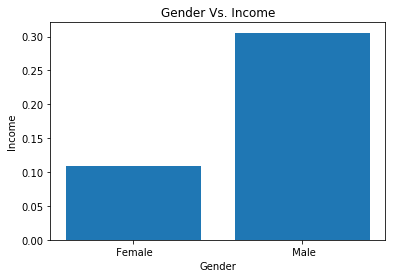

In [2]:
query =  """SELECT sex, avg(income) 
            FROM adult 
            GROUP BY sex;"""
cur.execute(query)
rows = cur.fetchall()
    
gender = []
income = []
for row in rows:
    gender.append(row[0])
    income.append(row[1])
    
genderVsIncome = (gender, income)

plt.bar(*genderVsIncome);
plt.ylabel('Income');
plt.xlabel('Gender');
plt.title("Gender Vs. Income");
print("Apparent Bias?")


### Detection


To detect whether a query is biased with respect to V, we must first check [conditional mutual information](https://en.wikipedia.org/wiki/Conditional_mutual_information), $I(T;V|\Gamma_i)$. 

[Mutual Information](http://www.scholarpedia.org/article/Mutual_information)is a measure of the mutual dependence between two variables (how much information is obtained by observing the other variable). Mututal information is non-negative, symmetric, and is often measured in bits. 

As an example,the paper gives an example where average delay of airports is querried against two airlines (United Airlines and American Airlines). It was found that the estimated conditional mutual information is   $I(Carrier;Airport|\Gamma_i)=.25$. Using a test on the null hypothesis test $I(T;V|\Gamma_i)=0$, they found p-value$<.001$, and therefore they rejected the null hypothesis and they conclude the base query is biased.

### Explanation

HypDB outputs two explaining views based on the attributes ZZ(Z∪M):

#### Coarse Grained: 
HypeDB calculates and lists in descending order each attributes by thier degree of responsibility:

![alt text](degOfResp.png "Title")

The degree of responsibility is a number between 0 and 1, and measures the contribution of a single attribute to the inequality $I(T;V|\Gamma_i)>0$.


#### Fine-Grained:
This view is based on the degree of contribution to I(X;Y) > 0 as:

![alt text](degOfCond.png "Title")

which can be any real number. HypeDB ranks tuples $(t,y,z) \in D$ based on their contribution to $I(T;Z)$ and $I(Y;Z)$ and combines them using a specific aggregation method and ranking the top contributors:

So for our adult example:

![alt text](biasQuery.png "Title")

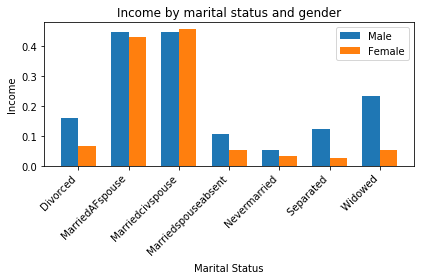

In [3]:
query =  """SELECT sex, maritalstatus, avg(income) 
            FROM adult 
            GROUP BY sex, maritalstatus;"""
cur.execute(query)
rows = cur.fetchall()

fMs = []
fIncome = []
mMs = []
mIncome = []
maritalstatus = []
for row in rows:
    if row[0]==' Female':
        fIncome.append(row[2])
        maritalstatus.append(row[1])
    else:
        mIncome.append(row[2])

x = np.arange(len(maritalstatus)) 
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mIncome, width, label='Male')
rects2 = ax.bar(x + width/2, fIncome, width, label='Female')

ax.set_ylabel('Income')
ax.set_xlabel('Marital Status');
ax.set_title('Income by marital status and gender')
ax.set_xticks(x)
ax.set_xticklabels(maritalstatus)
ax.legend()
plt.xticks(rotation=45, ha='right');


fig.tight_layout()
plt.show()

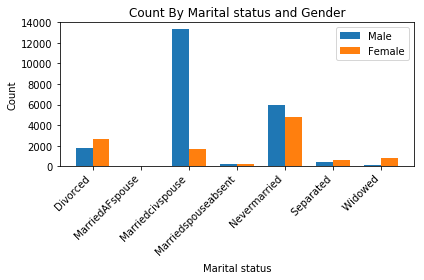

In [4]:
query =  """SELECT sex, maritalstatus, COUNT(*) 
            FROM adult 
            GROUP BY sex, maritalstatus;"""
cur.execute(query)
rows = cur.fetchall()

fN = []
mN = []
for row in rows:
    if row[0]==' Female':
        fN.append(row[2])
    else:
        mN.append(row[2])

x = np.arange(len(maritalstatus)) 
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mN, width, label='Male')
rects2 = ax.bar(x + width/2, fN, width, label='Female')

ax.set_ylabel('Count')
ax.set_xlabel('Marital status')
ax.set_title('Count By Marital status and Gender')
ax.set_xticks(x)
ax.set_xticklabels(maritalstatus)
ax.legend()
plt.xticks(rotation=45, ha='right');

fig.tight_layout()
plt.show()




### Resolve:

Instead do a wieghted average:

![alt text](generalQuery.png "Title")

Blocks: $E(Y|T,Z,X)$

Wieghts: $Pr(Z,X)$

Aggregating: $E(Y|T,X) = \Sigma_Z E(Y|T,Z,X)Pr(Z,X)$


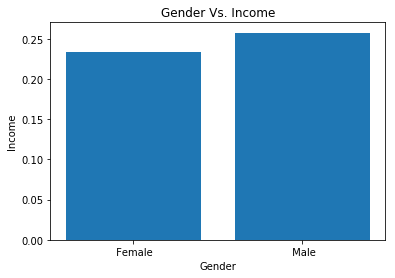

In [5]:
query = """
WITH Blocks AS (
    SELECT sex, maritalstatus, avg(income) AS Avge
    FROM adult
    GROUP BY sex, maritalstatus),
Weights AS (
    SELECT maritalstatus, CAST(count(*) AS float)/(SELECT count(*) FROM adult) AS W
    FROM adult
    GROUP BY maritalstatus
    HAVING count(DISTINCT sex)=2)
SELECT sex, sum(Avge*W)
FROM Blocks, Weights
WHERE Blocks.maritalstatus = Weights.maritalstatus
GROUP BY sex"""
cur.execute(query)
rows = cur.fetchall()
rows

gender = []
income = []
for row in rows:
    gender.append(row[0])
    income.append(row[1])
    
genderVsIncome = (gender, income)

plt.bar(*genderVsIncome);
plt.ylabel('Income');
plt.xlabel('Gender');
plt.title("Gender Vs. Income");

In [6]:
conn.close()